# 02. LangGraph Fundamentals

**Notebook Contents**:
- LangGraph Introduction
- Building Blocks of LangGraph
  - State
  - Node
  - Edge
  - Graph Construction and Invocation
- Building Your First LangGraph

## LangGraph Introduction

LangGraph is a low-level orchestration framework for building, managing, and deploying long-running, stateful agents. 

### Is LangGraph different from LangChain?
LangChain provides a standard interface to interact with models and other components, useful for retrieval, LLM calls and tools calls. The classes from LangChain might be used in LangGraph, but do not HAVE to be used.

The packages are different and can be used in isolation, but, in the end, all resources you will find online use both packages hand in hand.

### When should I use LangGraph?
If your application involves a series of steps that need to be orchestrated in a specific way, with decisions being made at each junction point, LangGraph provides the structure you need.

The key scenarios where LangGraph excels include:
- **Multi-step reasoning processes** that need explicit control on the flow
- **Applications requiring persistence** of state between steps
- **Systems that combine deterministic logic with AI capabilities**
- **Workflows that need human-in-the-loop interventions**
- **Complex agent architectures with multiple components working together**

### How does LangGraph work?
At its core, LangGraph uses a directed graph structure to define the flow of your application:
- **Nodes** represent individual processing steps (like calling an LLM, using a tool, or making a decision).
- **Edges** define the possible transitions between steps.
- **State** is user defined and maintained and passed between nodes during execution. When deciding which node to target next, this is the current state that we look at.

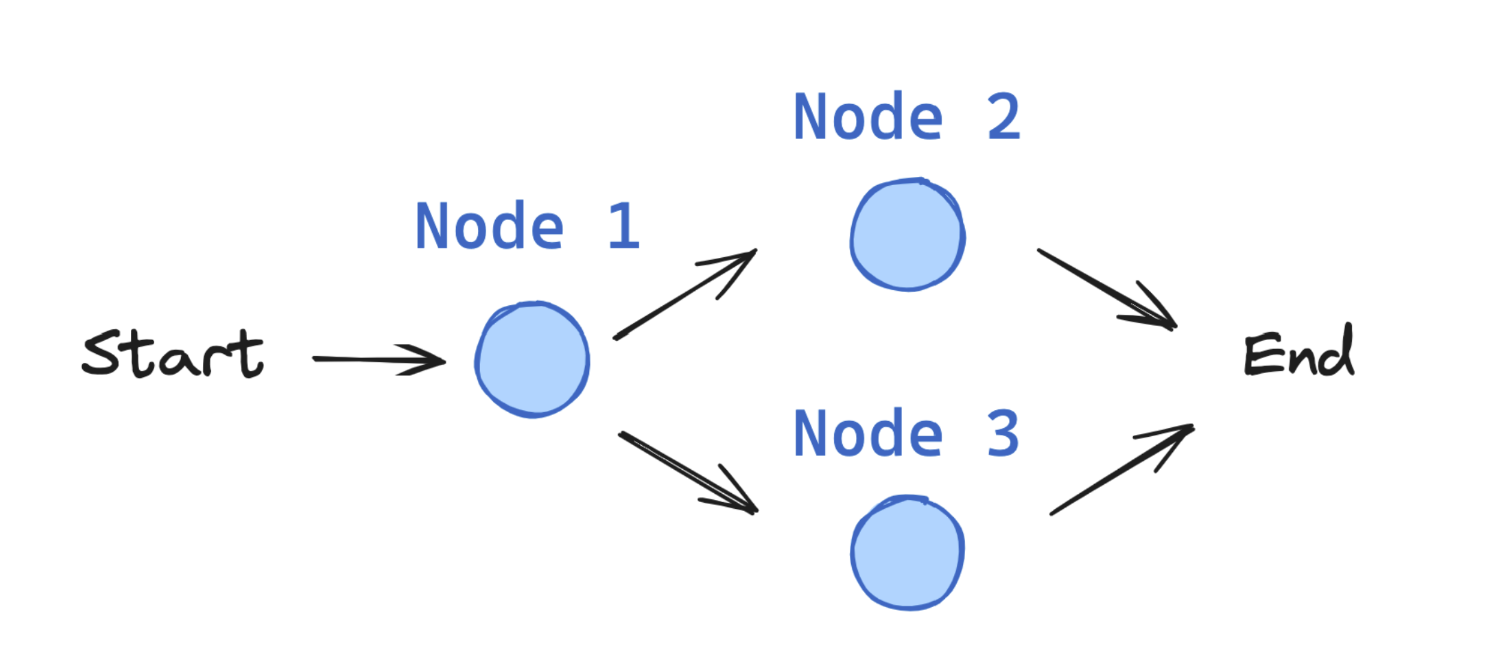


## Building Blocks of LangGraph

### State 

The first thing you do when you define a graph is define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph. The State consists of the schema of the graph as well as `reducer` functions which specify how to apply updates to the state. The schema of the State will be the input schema to all Nodes and Edges in the graph, and can be any Python type, but is typically a `TypedDict` or a `Pydantic` `BaseModel` model.

All `Nodes` will emit updates to the `State` which are then applied using the specified `reducer` function.

In [1]:
from typing import TypedDict

class State(TypedDict): 
    graph_state: str

>💡 Tip: Think carefully about what information your application needs to track between steps.

## Nodes

### Nodes 

**Nodes** are just python functions that encode the logic of your agents. Each node: 
- Takes the state as input 
- Performs some operation 
- Returns update to the state

Nodes can contain: 
- LLM calls: Generate text or make decisions
- Tool Calls: Interact with external systems
- Conditional Logic
- Human Intervention: Get input from users
>Some Nodes necessary for the whole workflow like *START* and *END* exist from LangGraph directly.

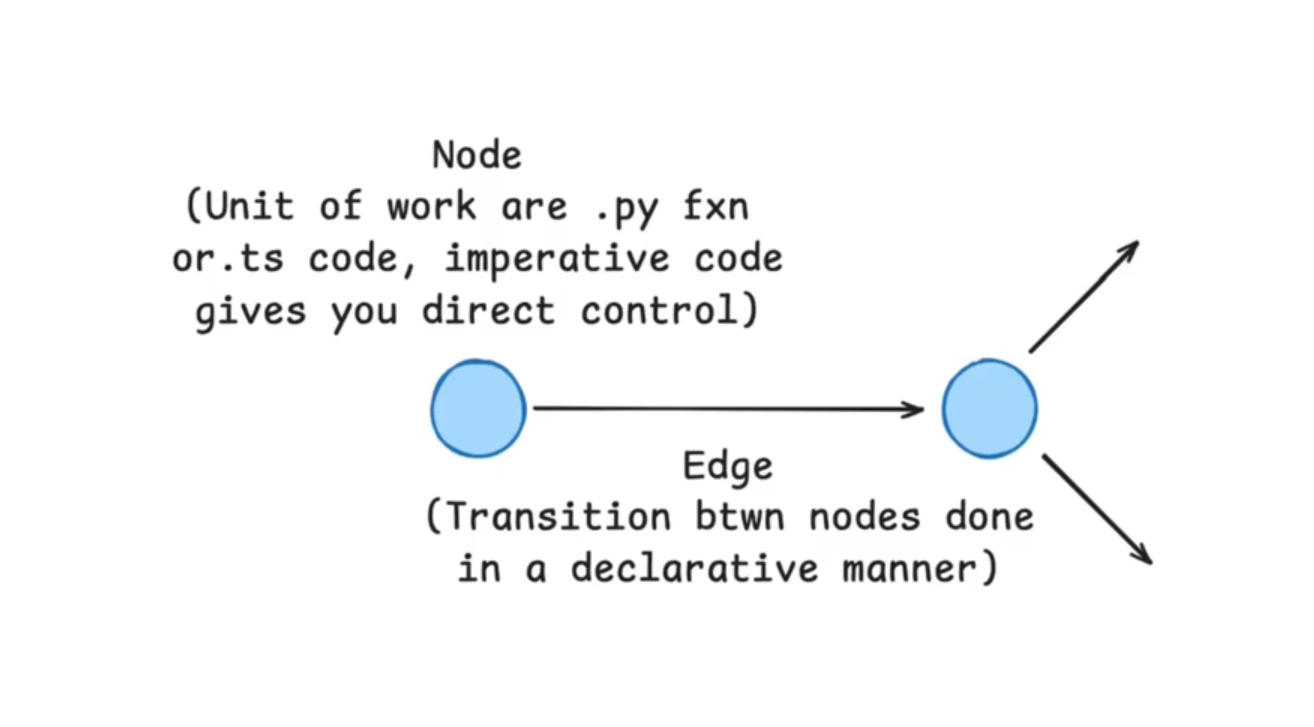

In [2]:
def node_1(state): 
    print("---Node 1---")
    return {"graph_state": state['graph_state'] + " I am"}

def node_2(state): 
    print("---Node 2---") 
    return {"graph_state": state["graph_state"] + " happy!"} 

def node_3(state): 
    print("---Node 3---") 
    return {"graph_state": state["graph_state"] + " sad!"} 


### Edges

**Edges** connect the nodes, define how the logic is routed, and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. 

There are a few key types of edges:

#### Normal Edges: 
Go directly from one node to the next.
  ```python 
  graph.add_edge("node_a", "node_b")
  ```
  
#### Conditional Edges: 
Call a function to determine which node(s) to go to next.
  ```python 
  graph.add_conditional_edges("node_a", routing_function) 
  ```
  
#### Entry Point: 
Which node to call first when user input arrives. \
When you want more control, e.g. multiple possible starting nodes or conditional logic.
  ```python 
  from langgraph.graph import START
  
  graph.add_edge(START, "node_a")
  ```
When your graph has a single obvious starting node and you don’t need extra branching from START.
```python
graph.set_entry_point("node_a")
```
#### Conditional Entry Point: 
Call a function to determine which node(s) to call first when user input arrives.
  ```python 
  from langgraph.graph import START
  
  graph.add_conditional_edges(START, routing_function)
  ```

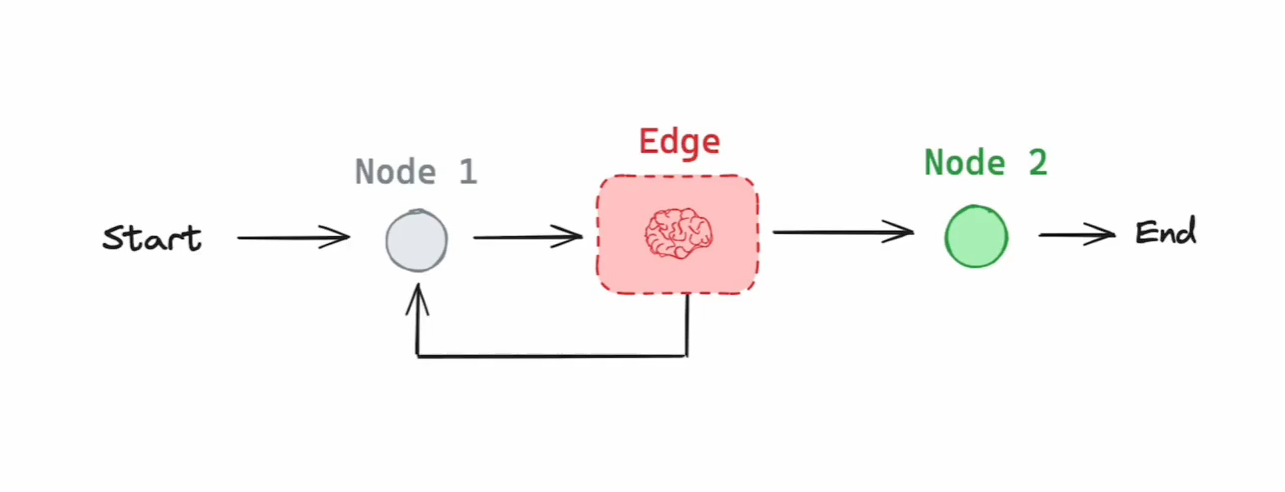

In [3]:
import random 
from typing import Literal 

def decide_mood(state) -> Literal["node_2", "node_3"]: 
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 

    # Here, let's just do a 50/50 split between nodes 2, 3 
    if random.random() < 0.5: 

        # 50% of the time, we return node 2 
        return "node_2" 

    # 50% of the time, we return node 3 
    return "node_3"     

### Graph Construction `StateGraph` 

The StateGraph is the container that holds your entire agent workflow. Now, we build the graph from our components defined above. The `StateGraph` class is the graph class that we can use.

First, we initialize a `StateGraph` with the `State` class we defined above.

Then, we add our nodes and edges.

We use the `START` Node, a special node that sends user input to the graph, to indicate where to start our graph.The `END` Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

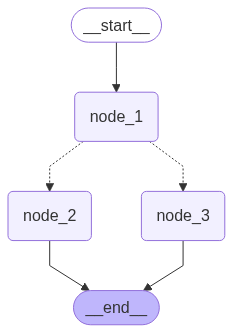

In [4]:
from IPython.display import Image, display 
from langgraph.graph import StateGraph, START, END 

# Build graph 
builder = StateGraph(State) 
builder.add_node("node_1", node_1) 
builder.add_node("node_2", node_2) 
builder.add_node("node_3", node_3) 

# Logic 
builder.add_edge(START, "node_1") 
builder.add_conditional_edges("node_1", decide_mood) 
builder.add_edge("node_2", END) 
builder.add_edge("node_3", END)  

# Add 
graph = builder.compile() 

# View 
display(Image(graph.get_graph().draw_mermaid_png()))

Alternatively, you can also use `.add_sequence([...])` to add nodes. 

It automatically maps "node_1" to node_1 function and so on for other nodes. 

```python 
builder = StateGraph(State).add_sequence([node_1, node_2, node_3])
```

### Graph Invocation

The compiled graph implements the [runnable](https://python.langchain.com/docs/concepts/runnables/) protocol. This provides a standard way to execute LangChain components. 

The input is a dictionary `{"graph_state": "Hi, this is Lance."}`, which sets the initial value for our graph state dict.

When `invoke` is called, the graph starts execution from the `START` node. 

It progresses through the defined nodes `(node_1, node_2, node_3)` in order. The conditional edge will traverse from `node 1` to `node 2` or `node 3` using a 50/50 decision rule. 

Each node function receives the current state and returns a new value, which overrides the graph state. The execution continues until it reaches the `END` node.

In [5]:
graph.invoke({"graph_state": "Hi, this is Lance."}) 

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

## Building Your First LangGraph

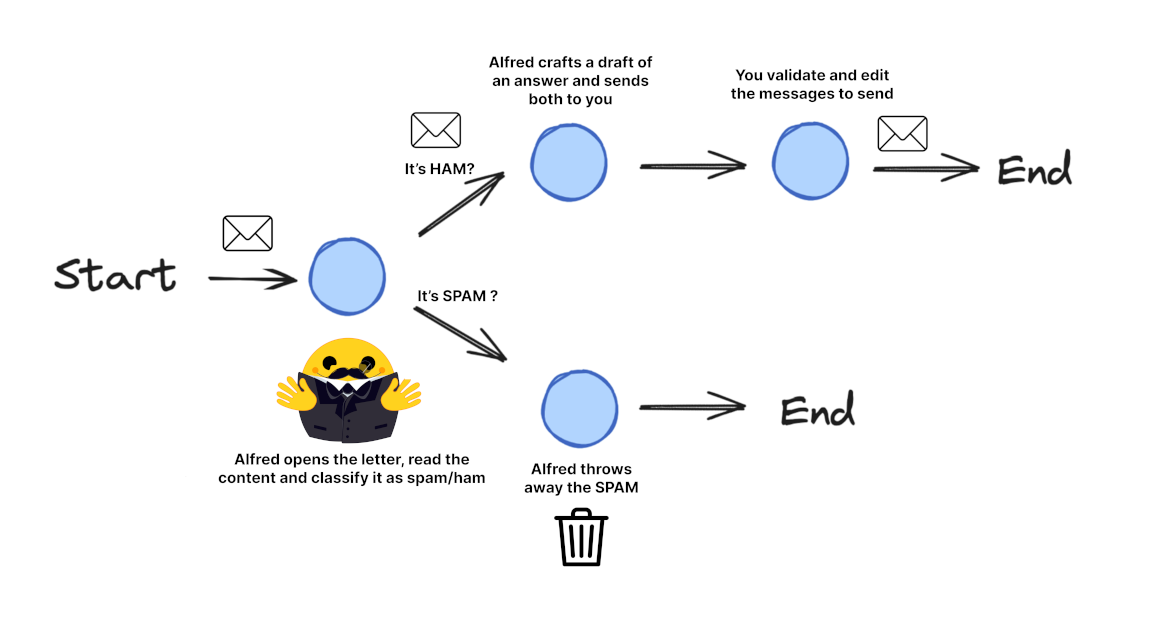

### Setting up environment

In [6]:
from dotenv import load_dotenv
import os

# Load .env file from the project root
load_dotenv()

gemini_api_key = os.getenv("GEMINI_API_KEY")

if gemini_api_key is None:
    raise ValueError("GEMINI_API_KEY not found. Please set it in the .env file.")

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash", 
    temperature = 0, 
    api_key = gemini_api_key
)

### Define Our State

In [16]:
from typing import TypedDict, List, Dict, Any, Optional

class EmailState(TypedDict):
    # email being processed 
    email: Dict[str, Any]  # contains subject, sender, body, etc. 

    # category of the email (inquity, complaint, etc) 
    email_category: Optional[str] 

    # reason for makring email as spam 
    spam_reason: Optional[str] 

    # analysis and decisions 
    is_spam: Optional[bool] 

    # response generation 
    email_draft: Optional[str]

    # processing metadata 
    messages: List[Dict[str, Any]]   # Track conversations with LLM for analysis 

### Define our Nodes 

In [34]:
from langchain_core.messages import HumanMessage

def read_email(state: EmailState): 
    """
    Agent reads and logs the incoming email
    """
    email = state["email"]

    # Initial preprocessing 
    print(f"Agent is processing an email from {email['sender']} with subject: {email['subject']}")

    # No state changes needed in this node 
    return {} 


def classify_email(state: EmailState): 
    """
    Agent uses an LLM to determine if the email is spam or legitimate
    """ 
    email = state["email"] 

    # Prepare our prompt for the LLM 
    prompt = f"""
    As an AI Agent, analyze this email and determine if it is spam or legitimate. 

    Email: 
    From: {email['sender']} 
    Subject: {email['subject']} 
    Body: {email['body']} 

    First, determine if this email is spam. If it is spam, explain why. 
    If it is not spam, categorize it (e.g. inquiry, complaint, thank you, etc.). 
    """ 

    # Call the LLM 
    messages = [HumanMessage(content=prompt)] 
    response = model.invoke(messages) 

    # Pase the response 
    response_text = response.content.lower() 
    is_spam = "spam" in response_text and "not spam" not in response_text

    # Extract a reason if it's spam 
    spam_reason = None 
    if is_spam and "reason:" in response_text: 
        spam_reason = response_text.split("reason:")[1].strip() 

    # Determine category if legitimate 
    email_category = None 
    if not is_spam: 
        categories = ["inquiry", "complaint", "thank you", "request", "information"] 
        for category in categories: 
            if category in response_text: 
                email_category = category 
                break 

    # Update messages for tracking 
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt}, 
        {"role": "assistant", "content": response.content} 
    ]

    # return state updates 
    return {
        "is_spam": is_spam, 
        "spam_reason": spam_reason, 
        "email_category": email_category, 
        "messages": new_messages
    }


def handle_spam(state: EmailState): 
    """ 
    Agent discards spam email with a note""" 
    print(f"\nAgent has marked the email as spam, Reason: {state['spam_reason']}") 
    print("The email has been moved to the spam folder") 
    return {} 


def draft_response(state: EmailState): 
    """ 
    Agent drafts a preliminary response for legitimate emails""" 
    email = state['email'] 
    category = state['email_category'] or "general" 

    # prepare prompt for LLM 
    prompt = f""" 
    As an Agent, draft a polite preliminary response to this email. 

    Email:  
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that receiver can review and personalize before sending.
    """ 

    # call the LLM 
    messages = [HumanMessage(content=prompt)] 
    response = model.invoke(messages) 

    # update messages for tracking 
    new_messages = state.get("messages", []) + [ 
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]

    # return state updates
    return {
        "email_draft": response.content, 
        "messages": new_messages
    } 


def notify_receiver(state: EmailState): 
    """ 
    Agent notifies receiver about the email and presents the draft response""" 
    email = state["email"] 

    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    return {}

### Define our Routing Logic 

In [35]:
def route_email(state: EmailState) -> str: 
    """ Determines the next step based on spam classification """ 
    if state["is_spam"]: 
        return "spam" 
    else: 
        return "legitimate" 

This routing function is called by LangGraph to determie which edge to follow after the spam classification node.

### Create the StateGraph and Define edges 

Now we are going to connect everything 

In [36]:
from langgraph.graph import START, END, StateGraph

# create the graph 
email_graph = StateGraph(EmailState) 

# Add nodes 
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email) 
email_graph.add_node("handle_spam", handle_spam) 
email_graph.add_node("draft_response", draft_response) 
email_graph.add_node("notify_receiver", notify_receiver) 

# Start the edges 
email_graph.add_edge(START, "read_email") 
email_graph.add_edge("read_email", "classify_email") 

# add conditional branching from cclassify_email
email_graph.add_conditional_edges(
    "classify_email", 
    route_email, 
    {
        "spam": "handle_spam", 
        "legitimate": "draft_response"
    }
)

# add the final edges
email_graph.add_edge("handle_spam", END) 
email_graph.add_edge("draft_response", "notify_receiver") 
email_graph.add_edge("notify_receiver", END)

# compile graph 
compiled_graph = email_graph.compile()

### Run the Application

In [38]:
# Example legitimate email 
legitimate_email = {
    "sender": "john.smith@example.com", 
    "subject": "Question about your services", 
    "body": "Dear Mr. Dipesh, I was referred to you by a colleague and I'm interested in learning about your consiulting services. Could we schedule a cal next week? Best regrads, John Smith." 
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# Process the legitimate email 
print("\n Processing the legitmate email...") 
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email, 
    "is_spam": None, 
    "spam_reason": None, 
    "email_category": None, 
    "email_draft": None, 
    "messages": [] 
}) 

# Process the spam email 
print("\nProcessing the spam email...") 
spam_result = compiled_graph.invoke({
    "email": spam_email, 
    "is_spam": None, 
    "spam_reason": None, 
    "email_category": None, 
    "email_draft": None, 
    "messages": []
})


 Processing the legitmate email...
Agent is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Subject: Re: Question about your services

Dear John,

Thank you for reaching out and for your interest in our consulting services. It's great to hear you were referred by a colleague.

I'd be happy to schedule a call next week to discuss how we can assist you. To make scheduling convenient, please feel free to book a time directly via my calendar link here: [**Insert Your Calendar Link Here**]. Alternatively, please let me know a few times that work best for you next week, and I'll do my best to accommodate.

Looking forward to connecting.

Best regards,

Dipesh


Processing the spam email...
Agent is processing an email from winner@lotter

## References

- Hugging Face - Agents Course - [Building Blocks of LangGraph](https://huggingface.co/learn/agents-course/unit2/langgraph/building_blocks)
- LangChain Academy - [Introduction to LangGraph Course](https://academy.langchain.com/courses/intro-to-langgraph)
- GitHub - [langchain-academy](https://github.com/langchain-ai/langchain-academy) (Code for Introduction to LangGraph course)
- LangGraph - [Graph API Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/) (see for more detailed info)
- Hugging Face - Agents Course - [Building Your First LangGraph](https://huggingface.co/learn/agents-course/unit2/langgraph/first_graph)
